# Install all necessary components


In [ ]:
!python --version
!pip freeze | grep torch
!pip install torchfile
!pip install ffmpeg

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5713 sha256=726c541234b312cf81b48b087fd79d7e27c9dff6fc8482dbfed2c0d04de683ab
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchfile
  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp36-none-any.whl size=6083 sha256=a475dbcef1c01c2bf1ededf852008164413862b4456f97c230e6140d9ef0985c
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq ./drive/My\ Drive/Colab\ Notebooks/Official-implementation-StyleMixer.zip

In [ ]:
import os
import io
import cv2
from PIL import Image
import imageio
import numpy as np
import torch
from google.colab import files
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython import display as ipythondisplay
from IPython.display import Image as ipythonimage

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1646592/45929032 bytes (3.6%)5120000/45929032 bytes (11.1%)9388032/45929032 bytes (20.4%)13705216/45929032 bytes (29.8%)17899520/45929032 bytes (39.0%)22044672/45929032 bytes (48.0%)26386432/45929032 bytes (57.5%)30638080/45929032 bytes (66.7%)34938880/45929032 bytes (76.1%)39215104/45929032 bytes (85.4%)43491328/45929032 bytes (94.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.

In [ ]:
%cd /content/Official-implementation-StyleMixer/checkpoint

/content/Official-implementation-StyleMixer/checkpoint


#Upload video (content)

In [ ]:
from google.colab import files
import os
import cv2

uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one video at a time!')

vid = uploaded[0]
os.rename(vid, vid.replace(" ", ""))
vid = vid.replace(" ", "")


fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))

Saving bird.mp4 to bird.mp4


 # Split video into frames

First frame:



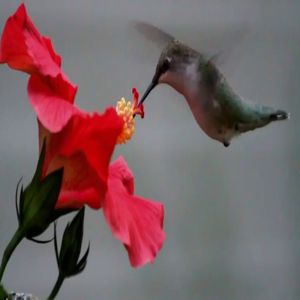

In [ ]:
from PIL import Image
!rm -rf frames
!mkdir frames

frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture(vid)
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

frames = []
fram = os.listdir("/content/Official-implementation-StyleMixer/checkpoint/frames")
fram.sort()

if not os.path.exists("/content/Official-implementation-StyleMixer/checkpoint/frames"):
  os.makedirs("/content/Official-implementation-StyleMixer/checkpoint/frames")

fram_path = '/content/Official-implementation-StyleMixer/checkpoint/frames/' + fram[0]
print("First frame:\n")
display(Image.open(fram_path).resize((300, 300)))



# update two style 

Saving s1.jpg to s1.jpg
User uploaded file "s1.jpg" with length 71586 bytes


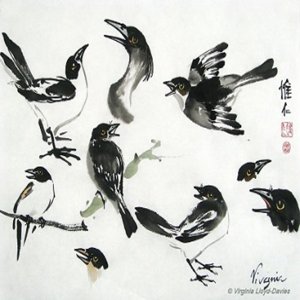

In [ ]:
uploaded_s1 = files.upload()
for s1 in uploaded_s1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=s1, length=len(uploaded_s1[s1])))
os.rename(s1, s1.replace(" ", ""))
s1 = s1.replace(" ", "")
pic_s1 = "style1." + s1.split(".")[-1]
!mv -f $s1 $pic_s1

display(Image.open(pic_s1).resize((300, 300)))

Saving s2.jpg to s2.jpg
User uploaded file "s2.jpg" with length 188483 bytes


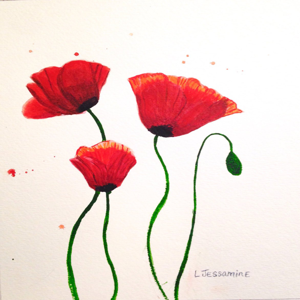

In [ ]:
uploaded_s2 = files.upload()
for s2 in uploaded_s2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=s2, length=len(uploaded_s2[s2])))
os.rename(s2, s2.replace(" ", ""))
s2 = s2.replace(" ", "")
pic_s2 = "style2." + s2.split(".")[-1]
!mv -f $s2 $pic_s2

display(Image.open(pic_s2).resize((300, 300)))

# style transfer

In [ ]:
%%time
from IPython.display import clear_output
!rm -rf stylized_frames
!mkdir stylized_frames

im = Image.open(fram_path)
(width, height) = im.size
max_cont_size = max(width, height)

if not os.path.exists("/content/Official-implementation-StyleMixer/checkpoint/stylized_frames"):
  os.makedirs("/content/Official-implementation-StyleMixer/checkpoint/stylized_frames")

for i in range(len(fram)):
  temp_path = '/content/Official-implementation-StyleMixer/checkpoint/frames/' + fram[i]  # 被切的frame
  output_path = '/content/Official-implementation-StyleMixer/checkpoint/stylized_frames/stylized_' + fram[i]
  !python /content/Official-implementation-StyleMixer/test_mult.py --name styleMixer_bw1_style3.00_cont3.00_iden1.00_cx3.00_1 --content $temp_path --style /content/Official-implementation-StyleMixer/checkpoint/style1.jpg,/content/Official-implementation-StyleMixer/checkpoint/style2.jpg
  perc = round(((len(fram)-(i+1))*100)/len(fram))
  if perc % 10 == 0:
    clear_output()
    print("完成: {}%".format(str(100 - perc)))
    print("剩幾個frame: {}".format(str(len(fram)-(i+1))))
clear_output()

CPU times: user 5.27 s, sys: 2.16 s, total: 7.42 s
Wall time: 36min 16s


In [ ]:
!pip install ffmpeg

In [ ]:
%cd /content/Official-implementation-StyleMixer/checkpoint/

/content/Official-implementation-StyleMixer/checkpoint


# Join frames in a video

In [ ]:
# !ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f mp3 sound.mp3
!ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f 
staffs = []
img = os.listdir("/content/Official-implementation-StyleMixer/checkpoint/stylized_frames/styleMixer_bw1_style3.00_cont3.00_iden1.00_cx3.00_1")
img.sort()
for i in img:
  staffs.append("/content/Official-implementation-StyleMixer/checkpoint/stylized_frames/styleMixer_bw1_style3.00_cont3.00_iden1.00_cx3.00_1/"+i)

staff = cv2.imread(staffs[0])  # get size from the 1st frame
writer = cv2.VideoWriter(
    'stylized_video.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'),   # codec (*'DIVX', *'MP4V', *'FMP4', *'MJPG', *'XVID', *'MP4S')
    fps_of_video,  # fps
    (staff.shape[1], staff.shape[0]),  # width, height
    isColor=len(staff.shape) > 2)
for staff in map(cv2.imread, staffs):
    writer.write(staff)
writer.release()

dstvid = 'stylized_video.mp4'
tmpfile = dstvid.replace('.mp4', '-audio.mp4')
!ffmpeg  -i $dstvid $tmpfile
!rm -rf $dstvid
!mv -f $tmpfile $dstvid

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
display(mpy.ipython_display("/content/Official-implementation-StyleMixer/checkpoint/stylized_video.mp4", height=400, autoplay=1, loop=1, maxduration=600))

In [ ]:
files.download('/content/Official-implementation-StyleMixer/checkpoint/stylized_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>